In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from collections import Counter

random.seed(10)

In [2]:
# Hidden state space
S = [0, 1]
# Emission space
V = [1, 2, 3, 4, 5]
# Transition matrix
A = np.matrix([[0.8, 0.2], 
               [0.1, 0.9]])
# Initial distribution 
mu_0 = [0.5, 0.5]
# Emission matrix
B = np.matrix([[0.2, 0.5, 0.2, 0.1, 0],
               [0, 0.1, 0.4, 0.4, 0.1]])

In [3]:
def writeParametersToFile(S, V, A, mu_0, B, file):
    # Write parameters to file
    f = open(file, "w")
    f.write("State space: " + " ".join(str(s) for s in S) + "\n")
    f.write("Emission space: " + " ".join(str(v) for v in V) + "\n")
    f.write("Transition matrix: " + " ".join(str(a) for a in np.array(A).flatten()) + "\n")
    f.write("Initial distribution: " + " ".join(str(m) for m in mu_0) + "\n")
    f.write("Emission matrix: " + " ".join(str(b) for b in np.array(B).flatten()))
    f.close()

In [4]:
def writeEmissionToFile(emission, file):
    # Write parameters to file
    f = open(file, "w")
    f.write(" ".join(str(e) for e in emission) + "\n")

In [5]:
chromosome_file = open("s_cerevisiae_chromosome_III.fa", "r")

bases = "".join([line.strip() for line in chromosome_file.readlines()[1:]])
print("Number of bases: " + str(len(bases)))

Number of bases: 316620


In [6]:
# Split into 100 base pair windows
window_size = 100

split_bases = [bases[i : i + window_size] for i in range(0, len(bases), window_size)]

GC Statistics
-------------
Mean: 0.385
Median: 0.38
Standard deviation: 0.072
Minimum: 0.11
Maximum: 0.63
-------------


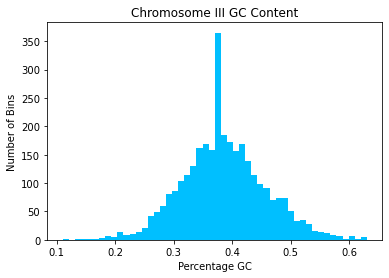

In [7]:
# Calculate the % of GC in each window
gc_content = [(window.count("G") + window.count("C")) / len(window) for window in split_bases]

decimal_places = 3

print("GC Statistics")
print("-------------")
print("Mean: " + str(round(np.mean(gc_content), decimal_places)))
print("Median: " + str(round(np.median(gc_content), decimal_places)))
print("Standard deviation: " + str(round(np.std(gc_content), decimal_places)))
print("Minimum: " + str(round(min(gc_content), decimal_places)))
print("Maximum: " + str(round(max(gc_content), decimal_places)))
print("-------------")

# Create histogram of GC content across bins
plt.hist(gc_content, bins = 50, color = "deepskyblue")
plt.title("Chromosome III GC Content")
plt.xlabel('Percentage GC')
plt.ylabel('Number of Bins')
plt.savefig("chromosome_bins.pdf", bbox_inches = 'tight')
plt.show()

In [14]:
# Assign emission states to bins
chromosome_emission = np.ones(len(gc_content))

for i in range(len(gc_content)):
    if 0.33 <= gc_content[i] < 0.37:
        chromosome_emission[i] = 2
    elif 0.37 <= gc_content[i] < 0.41:
        chromosome_emission[i] = 3
    elif 0.41 <= gc_content[i] < 0.45:
        chromosome_emission[i] = 4
    elif 0.45 <= gc_content[i]:
        chromosome_emission[i] = 5
        
# Write to file
writeEmissionToFile(chromosome_emission, file = "chromosome_emission.txt")        

print(chromosome_emission)
print(Counter(chromosome_emission))

[5. 5. 5. ... 5. 5. 5.]
Counter({3.0: 722, 1.0: 626, 5.0: 624, 2.0: 618, 4.0: 577})


In [20]:
class HMM():
    """
    S: state space
    V: emission space
    A: transition matrix
    mu_0: initial distribution
    B: emission matrix
    N: markov chain length
    """
    
    def __init__(self, S = None, V = None, A = None, mu_0 = None, B = None,
                 N = 100, file = None):
        
        self.readArray = lambda x: np.array(x.readline().split()).astype(float)
        self.readMatrix = lambda x: np.matrix(x.readline().split()[2:]).astype(float)
        
        if isinstance(file, type(None)):
            # If no file given, directly set parameters
            self.S = S
            self.V = V
            self.A = A
            self.mu_0 = mu_0
            self.B = B
            
        else:
            # Otherwise read parameters from a file
            f = open(file, "r")
            
            readArray = lambda x: np.array(x.readline().split()[2:]).astype(float)
            readMatrix = lambda x: np.matrix(x.readline().split()[2:]).astype(float)

            self.S = readArray(f)
            self.V = readArray(f)
            self.A = readMatrix(f)
            self.A.shape = (len(self.S), len(self.S))
            self.mu_0 = readArray(f)
            self.B = readMatrix(f)
            self.B.shape = (len(self.S), len(self.V))
            
        # Set the chain length
        self.N = N
        # Number of states
        self.J = len(self.S)

        # Map emitted state values to numerical indexes
        self.emit_idxs = dict(zip(self.V, [i for i in range(len(self.V))]))
        
    def markovChain(self):
        # Create markov chain
        chain = np.zeros(self.N)
        # Set the first state by sampling from the initial distribution
        chain[0] = np.random.choice(self.S, p = self.mu_0)
        
        # Set the remaining states in the chain
        for i in range(1, self.N):
            # Get the probability row from the transition matrix
            state_prob = np.array(self.A[int(chain[i - 1])]).flatten()
            # Sample from the state space
            chain[i] = np.random.choice(self.S, p = state_prob)
        
        return(chain)
    
    def emitStates(self, markov_chain):
        # Create output sequence
        emission = np.zeros(self.N)
        
        for i in range(self.N):
            # Get the probability row from the emission matrix
            emit_prob = np.array(self.B[int(markov_chain[i])]).flatten()
            # Sample from the emission matrix
            emission[i] = np.random.choice(self.V, p = emit_prob)
            
        return(emission)
    
    # Scaled forward algorithm
    def forwardAlgorithm(self, emitted_sequence = None, file = None):
        
        if not isinstance(file, type(None)):
            f = open(file, "r")
            emitted_sequence = self.readArray(f)
        
        # Initialise forward variables (alpha) and scale c
        a_hat = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        c = np.zeros(self.N, dtype = np.longfloat)
        
        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        v0 = int(sequence_idxs[0])
        
        a_hat[:, 0] = np.multiply(self.B[:, v0], self.mu_0[:].reshape(self.J, 1))
        c[0] = sum(np.multiply(np.array(self.B[:, v0]).flatten(), self.mu_0[:]))
        
        # Divide alphas by scaling factor
        for i in range(self.J):
            a_hat[i, 0] = a_hat[i, 0] / c[0]
            
        for n in range(1, self.N):
            # Get emission at position n
            vn = int(sequence_idxs[n])
            
            for i in range(self.J):
                # Calculate scale
                c[n] += self.B[i, vn] * sum(np.multiply(a_hat[:, n - 1], self.A[:, i]))
            
            for i in range(self.J):
                # Calculate scaled alpha
                a_hat[i, n] = (1/c[n]) * (self.B[i, vn] * sum(np.multiply(a_hat[:, n - 1], self.A[:, i])))
                
        # Calculate probability of data
        L = 0
        
        for n in range(self.N):
            L += math.log(c[n])
            
        return(L, a_hat, c, emitted_sequence)
    
    def backwardAlgorithm(self, emitted_sequence, c):
        # Initialise scaled backward variable
        b_hat = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        
        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        
        # Set inital values for BNi to BNj
        b_hat[:, self.N - 1] = 1/c[-1]
        
        for n in range(self.N - 2, -1, -1):
            # Get emission at position n + 1
            vn_plus_1 = int(sequence_idxs[n + 1])
            
            for i in range(self.J):
                # Calculate scaled backward variable
                b_hat[i, n] = (1/c[n]) * sum(np.multiply(np.multiply(b_hat[:, n + 1], self.A[i, :].reshape(self.J, 1)),
                                                        self.B[:, vn_plus_1]))
                
        return(b_hat)
    
    def generateProbability(self, size):
        # Generate random numbers
        probability = [random.randint(1, 10) for i in range(size)]
        # Scale between 0 - 1
        probability = np.array([float(i) / sum(probability) for i in probability])
        
        return(probability)
    
    def BaumWelchAlgorithm(self, emitted_sequence, threshold, verbose = 0):
        # Initialise parameters theta
        self.A = np.matrix(self.generateProbability(len(self.S)))
        self.mu_0 = self.generateProbability(len(self.S))
        self.B = np.matrix(self.generateProbability(len(self.V)))
        
        while self.A.shape[0] != len(self.S):
            self.A = np.vstack([self.A, self.generateProbability(len(self.S))])
            self.B = np.vstack([self.B, self.generateProbability(len(self.V))])

        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        v1 = int(sequence_idxs[1])
            
        # Initialise log likelihood
        L = float("inf")
        L_change = float("inf")
        
        # Calculate likelihood for initial parameters
        L_new, a_hat, c, _ = self.forwardAlgorithm(emitted_sequence)
        b_hat = self.backwardAlgorithm(emitted_sequence, c)
        
        count = 0
        
        if verbose > 0:
            print("Initial parameters:")
            print("A")
            print(self.A)
            print("B")
            print(self.B)
            print("mu_0")
            print(self.mu_0)
            print("\n")
        
        while (L_change > threshold):
            count += 1
            
            # Save previous state of A and B
            A = np.copy(self.A)
            B = np.copy(self.B)
            self.B = np.zeros_like(self.B)
            
            for i in range(self.J):
                for j in range(self.J):
                    self.A[i, j] = np.sum(A[i, j] * np.multiply(np.multiply(a_hat[i, :-1], 
                                                                            np.array([B[j, idx] for idx in sequence_idxs[1:]])),
                                                                b_hat[j, 1:]))
                
                    for vk in range(len(self.V)):
                        emitted_states = np.zeros_like(sequence_idxs)
                        state_idxs = [i for i, e in enumerate(sequence_idxs) if e == vk]
                        emitted_states[state_idxs] = 1
                        self.B[i, vk] += np.sum(A[i, j] * np.multiply(np.multiply(a_hat[i, :-1],
                                                                                  np.array([B[j, idx] for idx in sequence_idxs[1:]])),
                                                                      np.multiply(b_hat[j, 1:],
                                                                                  emitted_states[:-1])))
                # Divide by expectation
                self.B[i, :] = np.divide(self.B[i, :], np.sum(self.A[i, :]))
                self.A[i, :] = np.divide(self.A[i, :], np.sum(self.A[i, :]))
                
                self.mu_0[i] = np.sum(A[i, j] * np.multiply(np.multiply(a_hat[i, :-1],
                                                                          np.array([B[j, idx] for idx in sequence_idxs[1:]])),
                                                              b_hat[j, 1:]))
                    
                # Calculate updated mu
                self.mu_0[i] = a_hat[i, 0] * sum(np.array(np.multiply(np.multiply(A[i, :],
                                                                                  B[:, v1].flatten()),
                                                                      b_hat[:, 1].flatten())).flatten())

            # Normalise between 0 - 1 to account for underflow / rounding errors
            #self.mu_0 = np.array([float(i) / sum(self.mu_0) for i in self.mu_0])
            
            # Calculate likelihood for new parameters
            L_new, a_hat, c, _ = self.forwardAlgorithm(emitted_sequence)
            b_hat = self.backwardAlgorithm(emitted_sequence, c)
        
            # Difference in likelihood between previous and updated paramaters
            L_change = abs(L - L_new)
            L = L_new
            
            if verbose > 0:
                print("Iteration " + str(count) + ":")
                print("A")
                print(self.A)
                print("B")
                print(self.B)
                print("mu_0")
                print(self.mu_0)
                print("Log likelihood")
                print(L)
                print("\n")

        return(L)
    
    def ViterbiAlgorithm(self, emitted_sequence):
        # Viterbi sequence, traceback pointer and best states
        phi = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        psi = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        best_states = np.array(np.zeros(self.N))
        
        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        v0 = int(sequence_idxs[0])
        
        # Initialise first viterbi variable
        phi[:, 0] = np.reshape(np.array([math.log(m) for m in self.mu_0]) + np.array([math.log(b) for b in self.B[:, v0]]),
                        (self.J, 1))
        
        for n in range(1, self.N):
            # Get the value at position n in the emitted sequence
            vn = int(sequence_idxs[n])
            
            # Set the remaining viterbi variables
            for i in range(self.J):
                phi[i, n] = math.log(self.B[i, vn]) + max(np.array([math.log(self.A[i, j]) + phi[j, n - 1] for j in range(self.J)]))
                psi[i, n] = np.argmax(np.array([math.log(self.A[i, j]) + phi[j, n - 1] for j in range(self.J)]))
                
        # Traceback to find the best fitting states
        best_states[self.N - 1] = np.argmax([phi[i, self.N - 1] for i in range(self.J)])
        
        for n in range(self.N - 2, -1, -1):
            best_states[n] = psi[int(best_states[n + 1]), n + 1]
            
        return(best_states)

In [10]:
hmm = HMM(file = "hmm_params.txt", N = 115)
# Create the markov chain
m_chain = hmm.markovChain()
# Get the emitted states
emitted_sequence = hmm.emitStates(m_chain)

# Write emitted states to file
#writeEmissionToFile(emitted_sequence, file = "hmm_emission.txt")

# Run forward algorithm to get log likelihood from states saved to file
log_likelihood, _, _, file_emitted_sequence = hmm.forwardAlgorithm(file = "hmm_emission.txt")

print("Emitted sequence: " + str(file_emitted_sequence))
print("Log Likelihood: " + str(log_likelihood))

Emitted sequence: [3. 2. 1. 3. 2. 4. 3. 4. 2. 2. 2. 3. 3. 2. 3. 4. 3. 4. 4. 4. 4. 1. 2. 1.
 2. 1. 1. 2. 3. 3. 4. 3. 4. 3. 2. 1. 4. 2. 1. 4. 3. 2. 3. 2. 3. 3. 4. 3.
 5. 3. 4. 3. 3. 3. 4. 4. 3. 2. 2. 2. 4. 5. 3. 3. 2. 4. 2. 2. 3. 2. 2. 2.
 1. 3. 2. 2. 1. 2. 1. 3. 3. 2. 2. 2. 2. 4. 2. 3. 2. 3. 2. 3. 2. 3. 4. 5.
 4. 3. 3. 4. 5. 2. 3. 5. 4. 4. 4. 3. 3. 2. 2. 4. 4. 2. 4.]
Log Likelihood: -157.90431532917017


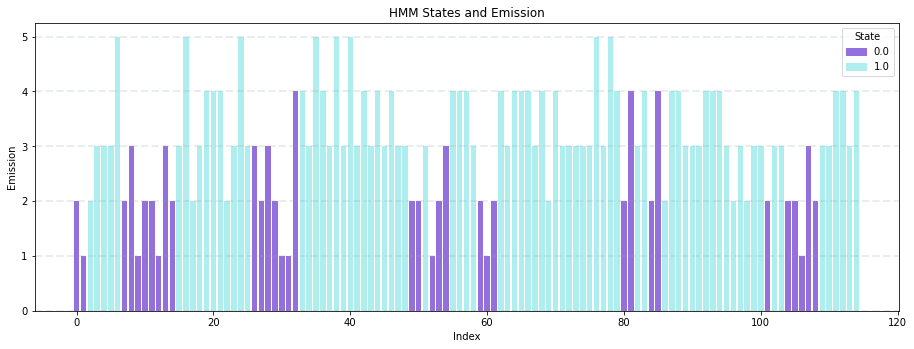

In [11]:
colour_dict = {0: "mediumpurple", 1: "paleturquoise", 2: "yellow", 3: "greenyellow", 4: "purple"}

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar([i for i in range(len(emitted_sequence))], emitted_sequence, color = [colour_dict[int(s)] for s in m_chain])
plt.grid(color = '#95a5a6', linestyle = '--', linewidth = 2, axis = 'y', alpha = 0.2)
plt.title('HMM States and Emission')
plt.xlabel('Index')
plt.ylabel('Emission')

plt.legend(handles = [mpatches.Patch(color = colour_dict[i],
                                     label = np.unique(m_chain)[i]) for i in range(len(np.unique(m_chain)))],
           title = "State")
plt.savefig("hmm_emission.pdf", bbox_inches = 'tight')
plt.show()

In [15]:
hmm_chromosome = HMM(file = "hmm_params.txt", N = len(chromosome_emission))
log_likelihood, _, _, _ = hmm_chromosome.forwardAlgorithm(file = "chromosome_emission.txt")

print("Log Likelihood: " + str(log_likelihood) + "\n")

new_log_likelihood = hmm_chromosome.BaumWelchAlgorithm(chromosome_emission, threshold = 0.01, verbose = 1)

print("Updated Log Likelihood: " + str(new_log_likelihood))

predicted_state = hmm_chromosome.ViterbiAlgorithm(chromosome_emission)

print("Predicted states: " + str(predicted_state))

Log Likelihood: -5481.273046395772

Initial parameters:
A
[[0.4 0.6]
 [0.5 0.5]]
B
[[0.09090909 0.3030303  0.18181818 0.21212121 0.21212121]
 [0.32       0.12       0.2        0.24       0.12      ]]
mu_0
[0.125 0.875]


Iteration 1:
A
[[0.41304074 0.58695926]
 [0.50196719 0.49803281]]
B
[[0.08428965 0.28782712 0.2130007  0.16575346 0.24912907]
 [0.29469228 0.1160195  0.24091061 0.19634936 0.15202826]]
mu_0
[0.19337689 0.80662311]
Log likelihood
-5091.280114177091


Iteration 2:
A
[[0.41788275 0.58211725]
 [0.49679695 0.50320305]]
B
[[0.08659863 0.28924259 0.21365979 0.1648136  0.24568539]
 [0.29253176 0.1149676  0.24032303 0.19712346 0.15505415]]
mu_0
[0.27393836 0.72606164]
Log likelihood
-5090.627144752283


Iteration 3:
A
[[0.42225359 0.57774641]
 [0.49221474 0.50778526]]
B
[[0.08856267 0.29041461 0.21418988 0.16399917 0.24283366]
 [0.29070595 0.11409874 0.23985173 0.19779316 0.15755042]]
mu_0
[0.36627756 0.63372244]
Log likelihood
-5090.12774997538


Iteration 4:
A
[[0.42625302 0.

Iteration 33:
A
[[0.55389331 0.44610669]
 [0.38998431 0.61001569]]
B
[[0.07009413 0.27053292 0.20760759 0.17145907 0.28030629]
 [0.30935674 0.12930945 0.24592587 0.19168603 0.12372191]]
mu_0
[9.99995899e-01 4.10110002e-06]
Log likelihood
-5075.272238929643


Iteration 34:
A
[[0.56854914 0.43145086]
 [0.37987019 0.62012981]]
B
[[0.06522017 0.26466156 0.20602431 0.17410963 0.28998432]
 [0.31444545 0.13401183 0.24744791 0.18941849 0.11467631]]
mu_0
[9.99998445e-01 1.55547109e-06]
Log likelihood
-5069.751063581125


Iteration 35:
A
[[0.58650635 0.41349365]
 [0.36708081 0.63291919]]
B
[[0.05950053 0.2570819  0.20411219 0.17752183 0.30178355]
 [0.32048965 0.14023813 0.24930644 0.1864472  0.10351858]]
mu_0
[9.99999496e-01 5.04437216e-07]
Log likelihood
-5061.044179214043


Iteration 36:
A
[[0.60861653 0.39138347]
 [0.35051899 0.64948101]]
B
[[0.05283618 0.24717078 0.20185798 0.18205921 0.31607585]
 [0.32753826 0.14863538 0.25151271 0.18241884 0.08989481]]
mu_0
[9.99999867e-01 1.32811723e-07]


Iteration 65:
A
[[0.90798079 0.09201921]
 [0.05069567 0.94930433]]
B
[[0.03242902 0.05781986 0.173644   0.24704594 0.48906118]
 [0.28879896 0.27089038 0.25802283 0.14654785 0.03573998]]
mu_0
[1.00000000e+00 1.57267073e-70]
Log likelihood
-4766.708797109712


Iteration 66:
A
[[0.90892458 0.09107542]
 [0.04995634 0.95004366]]
B
[[0.03276861 0.05787316 0.17298578 0.24679534 0.48957711]
 [0.28821459 0.2705303  0.25825289 0.14684137 0.03616086]]
mu_0
[1.00000000e+00 6.94453626e-73]
Log likelihood
-4766.653477428822


Iteration 67:
A
[[0.90973967 0.09026033]
 [0.04932282 0.95067718]]
B
[[0.03306445 0.05792269 0.17241675 0.24657832 0.49001778]
 [0.28771225 0.27021963 0.25845015 0.14709327 0.03652471]]
mu_0
[1.0000000e+00 3.0536793e-75]
Log likelihood
-4766.612170467939


Iteration 68:
A
[[0.91044167 0.08955833]
 [0.04878089 0.95121911]]
B
[[0.03332117 0.05796796 0.1719265  0.24639099 0.49039338]
 [0.28728138 0.26995234 0.25861887 0.14730901 0.0368384 ]]
mu_0
[1.00000000e+00 1.33769435e-77]
Lo

In [23]:
print(Counter(predicted_state))
print(len(chromosome_emission))

Counter({1.0: 2129, 0.0: 1038})
3167


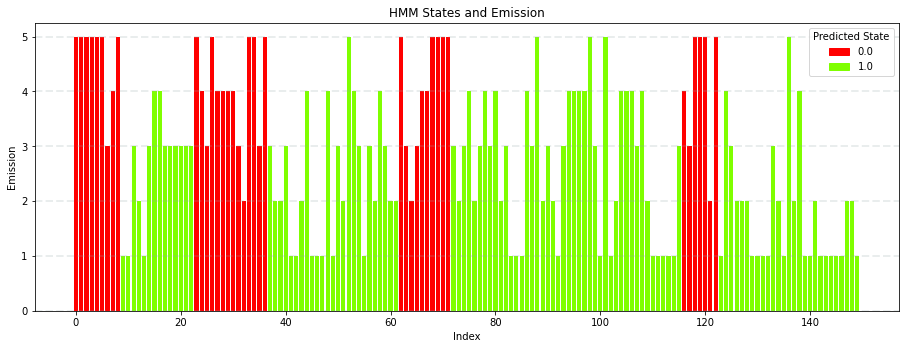

In [24]:
colour_dict = {0: "red", 1: "chartreuse", 2: "green", 3: "blue"}

min_position = 0
max_position = 150

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar([i for i in range(len(chromosome_emission[min_position : max_position]))],
       chromosome_emission[min_position : max_position],
       color = [colour_dict[int(s)] for s in predicted_state[min_position : max_position]])
plt.grid(color = '#95a5a6', linestyle = '--', linewidth = 2, axis = 'y', alpha = 0.2)
plt.title('HMM States and Emission')
plt.xlabel('Index')
plt.ylabel('Emission')

plt.legend(handles = [mpatches.Patch(color = colour_dict[i],
                                     label = np.unique(predicted_state[min_position : max_position])[i])
                      for i in range(len(np.unique(predicted_state[min_position : max_position])))],
           title = "Predicted State")
plt.savefig("chromosome_emission.pdf", bbox_inches = 'tight')
plt.show()